## Introduction and Background


In [1]:
#Import cartopy and pyplot modules to create map for introduction plus later plots
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt

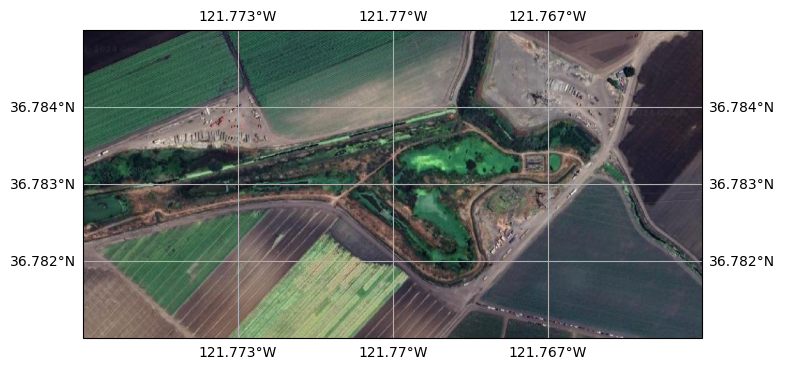

In [2]:
#Set latitudinal and longitudinal range of map
extent_wetland = [-121.775, -121.765, 36.781, 36.785]
# Request Google satellite image overlay
request = cimgt.GoogleTiles(style='satellite')
#Initialize figure and plot satellite imagery
plt.figure(figsize=[12,4])
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(extent_wetland)
ax.add_image(request, 17)
#Format gridlines and reduce number of axis ticks/labels
gl = ax.gridlines(draw_labels=True)
gl.ylocator = plt.MaxNLocator(4)
gl.xlocator = plt.MaxNLocator(4)

<b>Figure 1.</b> Overhead map of CSTW and Castroville Ditch feeding in from the Southeast.

## Data Source and Methodology

## Results

In [8]:
#Import packages and modules for data analysis and visualization
import pandas as pd
import CSWTBioreactorFunctions as CBRF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean.cm as cmo

In [5]:
dffb,dfclist,dfc1,dfc2,dfc3,dfc4,dfc5,dfc6,dfc7,dfc8,dfc9,dfc10,dfc11,dfc12 = CBRF.BR_fileimport()

## References